## Import


In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

# BERT
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_scheduler
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm

import gc
import warnings
warnings.filterwarnings('ignore')


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
df_reviews = pd.read_pickle('df_reviews.pkl')
df_reviews

,unique_id,user,rating,review date(months ago),title,comment,recommend,website,scaled_recommend,scaled_rating
0,27,Native New Yorker,5,0.13,Modern boot cut look,"Love the slim fit around the leg and the room, and boot cut before the leg.",Yes,levis,1,1.0
1,27,Cesh Hersan,5,0.23,Legend pants,I like the classics jeans. This is one of those!!!,Yes,levis,1,1.0
2,27,Briksolid,5,0.23,Perfect for me,great pants; fit perfectly; very comfortable and satisfied with this purchase,Yes,levis,1,1.0
3,27,Michael,5,0.30,Great jeans,Great jeans. Great cut. Been wearing these for years. Only get new ones when my size changes,Yes,levis,1,1.0
4,27,Michael,5,0.30,Great jeans,Great fit. Great cut. Good quality. Been wearing these for many years.,Yes,levis,1,1.0
...,...,...,...,...,...,...,...,...,...,...
93293,75,Darron,5,60.00,My new favorite,I was loyal to the 511 style for years but I am in love with the way these 512s fit. I will be buying more.,False,macys,0,1.0
93294,75,suzann,5,60.00,Great product,They fit my grandson perfect he loves Levi’s. Good product,False,macys,0,1.0
93295,75,Gdblues,1,60.00,Disappointed,I bought this pair and a darker blue pair. The latter fits the way 512's are supposed to fit. This one is way too baggy in the thighs and seat. I am returning it!,False,macys,0,-1.0
93296,75,Raydawg,5,84.00,Great style,I have all colors > please never get rid of 512 jeans,True,macys,1,1.0


In [3]:
df_reviews_1year_ago = df_reviews[df_reviews['review date(months ago)'] >= 12]
df_reviews_within_1year = df_reviews[df_reviews['review date(months ago)'] < 12]
del df_reviews; gc.collect()
df_reviews_1year_ago.shape, df_reviews_within_1year.shape


((64919, 10), (16458, 10))

## BERT

### load data

In [29]:
LABEL_COLUMN = 'scaled_rating'
label_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
df_train, df_test = train_test_split(df_reviews_1year_ago, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
# df_train[LABEL_COLUMN] = df_train[LABEL_COLUMN].map(label_mapping)
# df_val[LABEL_COLUMN] = df_val[LABEL_COLUMN].map(label_mapping)
# df_test[LABEL_COLUMN] = df_test[LABEL_COLUMN].map(label_mapping)
df_train.shape, df_val.shape, df_test.shape

((41548, 10), (10387, 10), (12984, 10))

In [7]:
# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [8]:
# Create dataset
class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        if row["title"]:
            text = row["title"] + "\n" + row["comment"]
        else:
            text = row["comment"]
        label = row[LABEL_COLUMN]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float),
        }

In [79]:
df_train = df_train.reset_index(drop=True)
train_dataset = SentimentDataset(df_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

df_test = df_test.reset_index(drop=True)
test_dataset = SentimentDataset(df_test, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

df_val = df_val.reset_index(drop=True)
val_dataset = SentimentDataset(df_val, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### Train

In [ ]:
# Load pre-trained BERT model
num_labels = 1  
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [ ]:
criterion = torch.nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 5
num_training_steps = len(train_loader) * epochs  
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

def train(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=True)

    for batch in progress_bar:
        input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.squeeze(-1)  # (batch_size, 1) -> (batch_size,)

        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        progress_bar.set_postfix({"Loss": loss.item()})

    return total_loss / len(train_loader)


def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    progress_bar = tqdm(val_loader, desc="Evaluating", leave=True)

    with torch.no_grad():
        for batch in progress_bar:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = outputs.logits.squeeze(-1)  # (batch_size, 1) -> (batch_size,)

            loss = criterion(predictions, labels)
            total_loss += loss.item()

            progress_bar.set_postfix({"Loss": loss.item()})

    return total_loss / len(val_loader)


In [69]:
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, lr_scheduler, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print("-"*50)

Evaluating: 100%|██████████| 650/650 [00:13<00:00, 49.74it/s, Loss=0.000215]


Epoch 1/5
Train Loss: 0.0474
Val Loss: 0.0766
--------------------------------------------------


Evaluating: 100%|██████████| 650/650 [00:13<00:00, 49.71it/s, Loss=0.000787]


Epoch 2/5
Train Loss: 0.0344
Val Loss: 0.0848
--------------------------------------------------


Evaluating: 100%|██████████| 650/650 [00:13<00:00, 49.91it/s, Loss=3.67e-6]


Epoch 3/5
Train Loss: 0.0256
Val Loss: 0.0772
--------------------------------------------------


Evaluating: 100%|██████████| 650/650 [00:13<00:00, 49.82it/s, Loss=0.000199]


Epoch 4/5
Train Loss: 0.0195
Val Loss: 0.0757
--------------------------------------------------


Evaluating: 100%|██████████| 650/650 [00:13<00:00, 49.63it/s, Loss=3e-5]    

Epoch 5/5
Train Loss: 0.0157
Val Loss: 0.0748
--------------------------------------------------


In [ ]:
def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing", leave=True)  

        for batch in progress_bar:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = outputs.logits.squeeze(-1)  # (batch_size, 1) -> (batch_size,)

            loss = criterion(predictions, labels)
            total_loss += loss.item()

            true_labels.extend(labels.cpu().numpy())  
            predicted_labels.extend(predictions.cpu().numpy())  

            progress_bar.set_postfix({"Loss": loss.item()})

    avg_loss = total_loss / len(test_loader)
    print(f"\nTest Loss: {avg_loss:.4f}")

    return np.array(true_labels), np.array(predicted_labels), avg_loss

true_labels, predicted_labels, test_loss = test(model, test_loader, criterion, device)
# predicted labels 
predicted_labels = np.clip(predicted_labels, -1, 1)


Testing: 100%|██████████| 812/812 [00:16<00:00, 49.68it/s, Loss=0.0103]  


Test Loss: 0.0794


In [ ]:
# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_model(true_labels, predicted_labels):

    mae = mean_absolute_error(true_labels, predicted_labels)
    print(f"MAE: {mae:.4f}")

    mse = mean_squared_error(true_labels, predicted_labels)
    print(f"MSE: {mse:.4f}")

    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")

    r2 = r2_score(true_labels, predicted_labels)
    print(f"R^2 Score: {r2:.4f}")

    return mae, mse, rmse, r2

mae, mse, rmse, r2 = evaluate_model(true_labels, predicted_labels)

MAE: 0.1328
MSE: 0.0787
RMSE: 0.2805
R^2 Score: 0.8286


In [ ]:
df_predictions = pd.DataFrame({
    "true_label": true_labels,
    "predicted_label": predicted_labels
})

df_test_results = df_test.copy()  
df_test_results["true_label"] = df_predictions["true_label"]
df_test_results["predicted_label"] = df_predictions["predicted_label"]

df_test_results["absolute error(rate)"] = np.abs(df_test_results["true_label"] - df_test_results["predicted_label"])


In [88]:
df_test_results[df_test_results['absolute error(rate)'] > 0.5].sort_values(by='absolute error(rate)', ascending=False).head(20)

,unique_id,user,rating,review date(months ago),title,comment,recommend,website,scaled_recommend,scaled_rating,true_label,predicted_label,absolute error(rate)
469,1,bigsexy,5,108.0,Did not fit,Did not fit waiting for returned last week waiting for refund,Yes,levis,1,1.0,1.0,-1.000000,2.000000
5789,41,hiwayhank,5,96.0,Icon gone,This will be the last time I purchase your product. You are big enough to have figured out a way to do it here.,False,macys,0,1.0,1.0,-1.000000,2.000000
10788,14,clkaseno,5,156.0,My husband did not like the color of these jeans.,I returned these 2 pair of 505 Levis and I have the delivery confirmation which says they were returned on June 7 and I still haven't gotten credit.,Yes,levis,1,1.0,1.0,-1.000000,2.000000
4180,41,Bobby Baltimore,5,36.0,Miss this fit,Haven't had Levi's in my wardrobe ten years. I'm never doing that again!,True,macys,1,1.0,1.0,-1.000000,2.000000
10340,14,lea anne,1,36.0,jeans,the only place you can find this size of jeans is online,None,levis,0,-1.0,-1.0,1.000000,2.000000
10883,53,anonymity,1,24.0,The best jeans ever!,"Since my early teens, Levi's have been my goto jeans. I am a 72 year old female, and these particular jeans were my impetus to lose weight. Because no matter how large, they looked and felt great. Started with a 35 waist, then a 34 waist, and now the third pair is a 33 waist. They tell a much loved story.",False,macys,0,-1.0,-1.0,1.000000,2.000000
6449,72,Jam031,1,108.0,Awesome,These are great quality. They look and feel great! My husband loves them111,False,macys,0,-1.0,-1.0,1.000000,2.000000
11880,268,Shamu,1,36.0,My favorite pants,Lees are now officially my brand. Consistent size that always fits me. Good quality and last forever. These are a heavier denim for cooler months. They give but don’t stretch out.,None,levis,0,-1.0,-1.0,0.999030,1.999030
11665,63,HGB1,1,48.0,I like to wear my jeans myself!,I like to wear my jeans myselfI like to wear my jeans myself!,False,macys,0,-1.0,-1.0,0.990974,1.990974
2100,59,Where,5,144.0,Levi's going extinct,"My husband wears a 35x32 and I can only find them in a very light stone washed jean. Why? Now I am having trouble finding them. I used to wear nothing but women's 550 and then they discontinued them. All you can find now are Women's stretch material. If that is what I wanted, I would purchase other brands. Bring back the 550 JEANS. If you must throw in stretch material, keep it to a minimium. Many women at my work are missing them also. Since the change I have bought zero Levis. Guess you don't need our business.Proslevis 550",Yes,levis,1,1.0,1.0,-0.978303,1.978303


In [16]:
def plot_distribution(true_labels, predicted_labels):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(true_labels, kde=True, color="blue", bins=20)
    plt.title("True Labels Distribution")
    plt.xlabel("True Label")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 2, 2)
    sns.histplot(predicted_labels, kde=True, color="orange", bins=20)
    plt.title("Predicted Labels Distribution")
    plt.xlabel("Predicted Label")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

def plot_scatter(true_labels, predicted_labels):
    plt.figure(figsize=(8, 6))
    plt.scatter(true_labels, predicted_labels, alpha=0.6, color='green', edgecolors='black')
    plt.plot([true_labels.min(), true_labels.max()], [true_labels.min(), true_labels.max()], color='red', linestyle='--')  # 理想的拟合线
    plt.title("True vs Predicted Labels")
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.grid(True)
    plt.show()

def plot_boxplot(true_labels, predicted_labels):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=true_labels, y=predicted_labels, color="purple")
    plt.title("True vs Predicted Labels")
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.show()

def plot_error_distribution(true_labels, predicted_labels):
    errors = true_labels - predicted_labels

    plt.figure(figsize=(8, 6))
    sns.histplot(errors, kde=True, color="purple", bins=20)
    plt.title("Error Distribution (True - Predicted)")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.show()


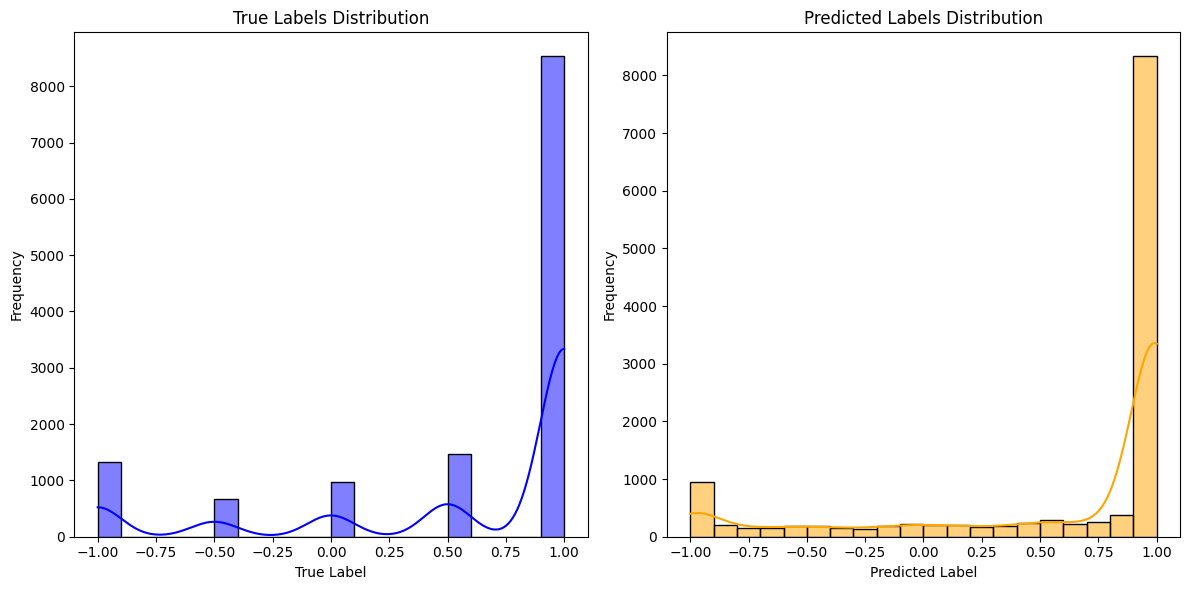

In [94]:
plot_distribution(df_test_results['scaled_rating'], df_test_results['predicted_label'])

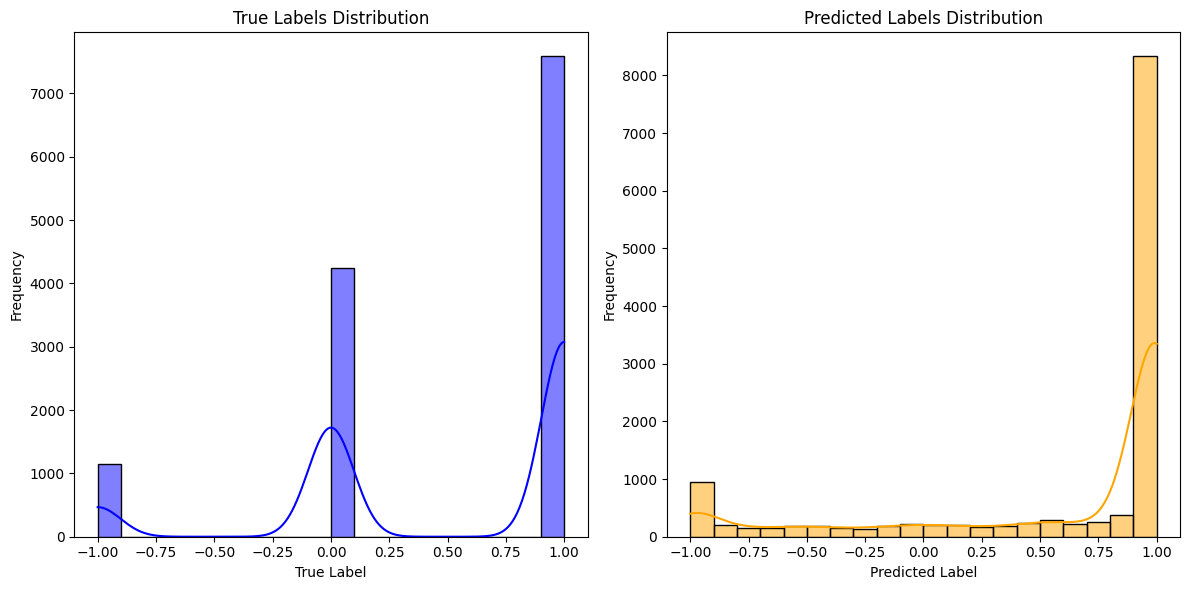

In [95]:
plot_distribution(df_test_results['scaled_recommend'], df_test_results['predicted_label'])

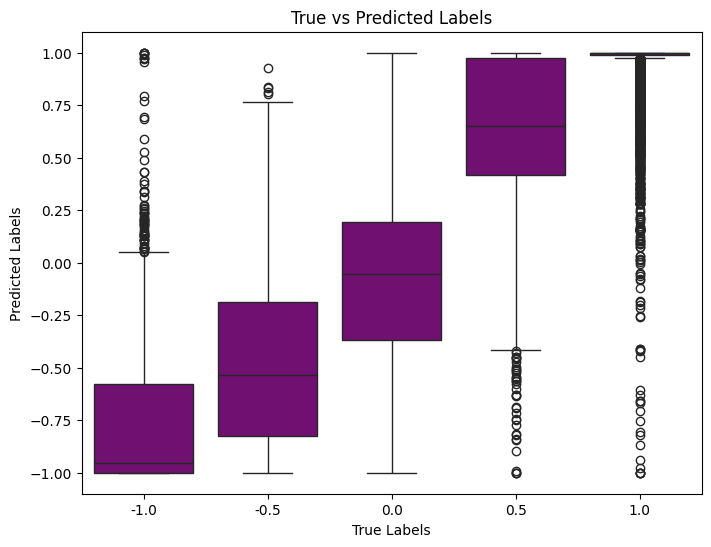

In [96]:
plot_boxplot(df_test_results['scaled_rating'], df_test_results['predicted_label'])

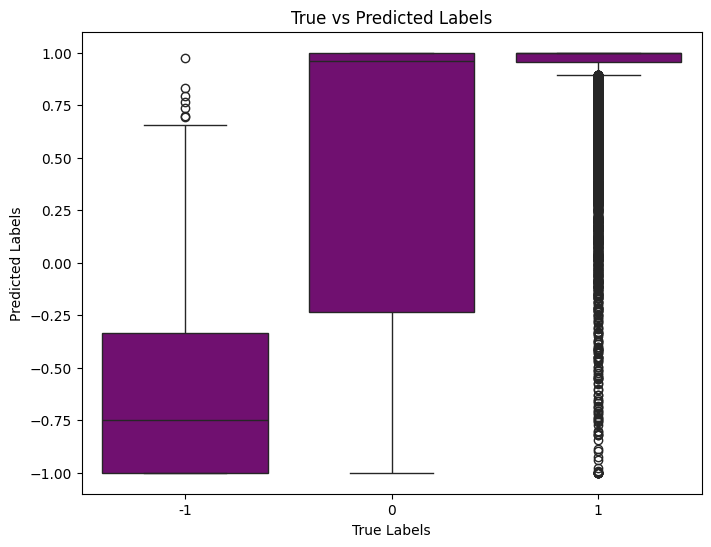

In [97]:
plot_boxplot(df_test_results['scaled_recommend'], df_test_results['predicted_label'])

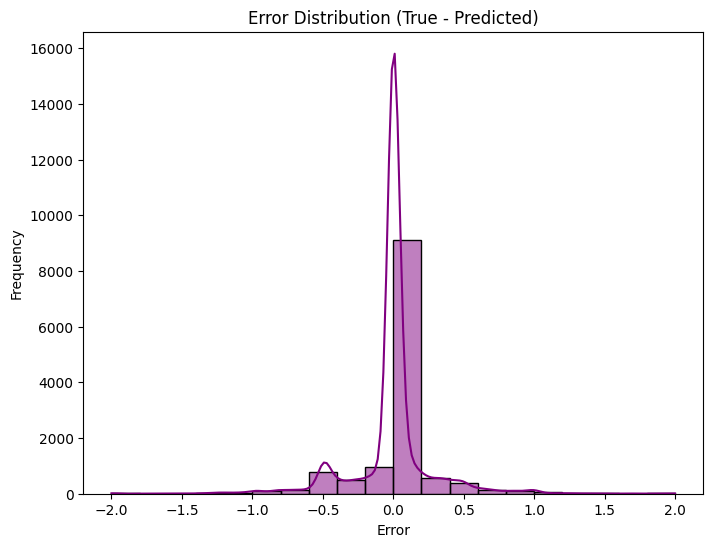

In [98]:
plot_error_distribution(df_test_results['scaled_rating'], df_test_results['predicted_label'])

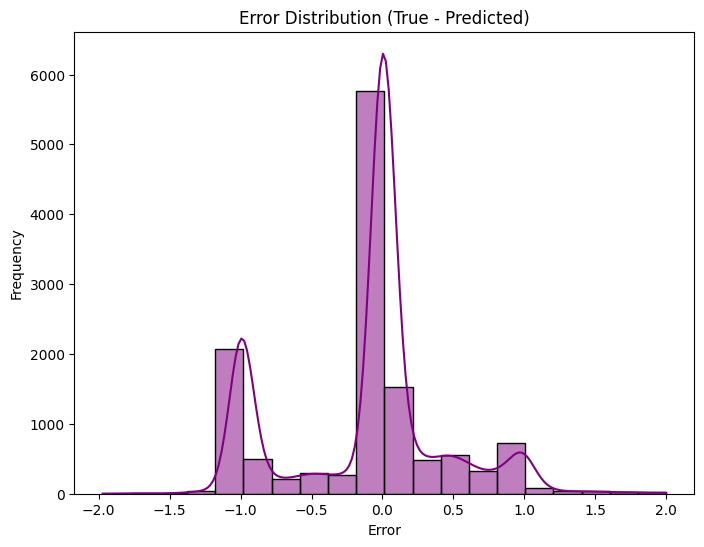

In [99]:
plot_error_distribution(df_test_results['scaled_recommend'], df_test_results['predicted_label'])

In [101]:
model.save_pretrained("bert_sentiment_model_0318")

In [102]:
df_test_results.to_pickle('df_test_results.pkl')

### load model

In [5]:
model = BertForSequenceClassification.from_pretrained("bert_sentiment_model_0318")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

Using device: cuda


In [6]:
# predict
def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Predicting", leave=True)

        for batch in progress_bar:
            input_ids, attention_mask = batch["input_ids"].to(device), batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.logits.squeeze(-1).cpu().numpy())

    return np.array(predictions)

In [23]:
LABEL_COLUMN = 'scaled_rating'
predict_dataset = SentimentDataset(df_reviews_1year_ago, tokenizer)
predict_loader = DataLoader(predict_dataset, batch_size=16, shuffle=False)


In [24]:
predicted_labels = predict(model, predict_loader, device)
predicted_labels = np.clip(predicted_labels, -1, 1)


Predicting: 100%|██████████| 4058/4058 [01:18<00:00, 52.01it/s]


In [25]:
df_reviews_1year_ago['predicted_label'] = predicted_labels

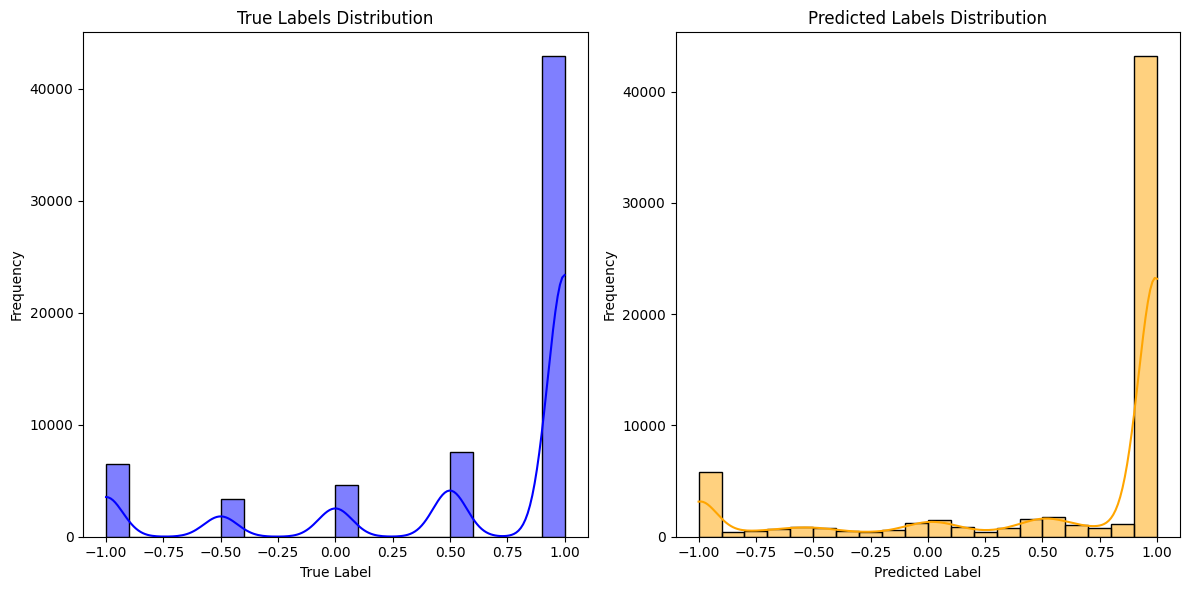

In [26]:
plot_distribution(df_reviews_1year_ago['scaled_rating'], df_reviews_1year_ago['predicted_label'])

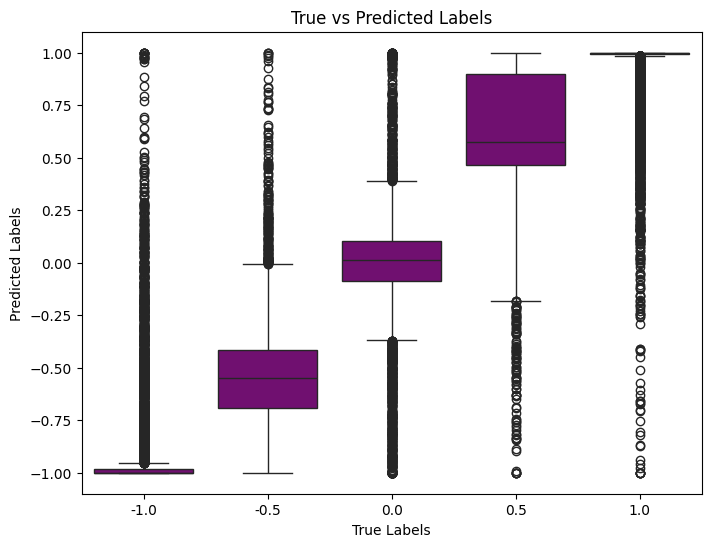

In [28]:
plot_boxplot(df_reviews_1year_ago['scaled_rating'], df_reviews_1year_ago['predicted_label'])

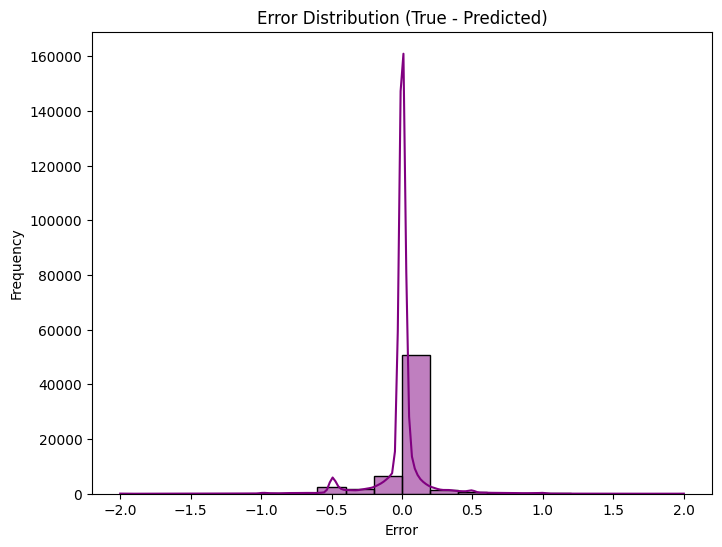

In [29]:
plot_error_distribution(df_reviews_1year_ago['scaled_rating'], df_reviews_1year_ago['predicted_label'])

In [30]:
df_reviews_1year_ago.to_pickle('df_reviews_1year_ago.pkl')